# Data Driven Modeling
<hr style="height:3px;border:none;color:stillblue;background-color:black;" />
### PhD seminar series at Chair for Computer Aided Architectural Design (CAAD), ETH Zurich


[Vahid Moosavi](https://vahidmoosavi.com/)
<hr style="height:1px;border:none;color:stillblue;background-color:black;" />

<a></a>

# Sixth Session 
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<span style="color:steelblue;font-size: 1em;"> 14 November 2017</span>


### Topics to be discussed 

 
* **Self Organizing Maps (SOM)**
    * ** SOM and clustering**
    * ** SOM and manifold learning**
    * ** SOM and probability density model**
    * ** SOM and dimensionality reduction**
    * ** SOM and visualization**
    * ** SOM and topological data analysis** 


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.__version__
import sys
from scipy import stats
%matplotlib inline

# Self Organizing Map (SOM)


# Basic idea:
# How to indirectly transform the data with topology consideration
## Original algorithm: transform (index) data points from a hig dimensional space to a low dimesional space in a topology preserving way
### Topology preserving means: Similar data points in the higher dimensional space are closer to each other in the lower dimensional space

![](Images/SOM.png)

# Reminders from last sessions: 
## Two approaches of space transformation (clustering)
* **Geometric (global) transformation: PCA, Kmeans**
* **Topological (local) transformation: DBSCAN (just for clustering) **

# Data abstraction
* ** with data abstraction: linear regression, K-means, GMM, PCA**
* ** Without data abstraction (usually in topological transformations)**


<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />

<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />
<hr style="height:1px;border:none;color:stillblue;background-color:steelblue;" />


## SOM somehow takes advantage of all them. 
### In fact, we are doing the transformation via some capsules (nodes)
### These capsules are similar to clusters in K-means, but with a difference that they are also locally similar to each other. 
### This means that the capsules try to learn from each other also in a competitive manner. This is opposite to PCA for example, that the PCs try to be completely independent of each other!

# The Original Algorithm
## Online learning

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Somtraining.svg/1000px-Somtraining.svg.png)


## 0- Assume we have a grid (e.g. 2D), where each node has an n-dimensional vector w, and a 2-D index, (x,y)
* Each node has two representational vector.
* Each node can be seen as the center of one cluster in K-means

## 1- We initialize ws with random vectors
## 2- for several runs repeat the following steps
* ** project each data point to the grid and find the most similar node (using the selected similarity measure) to that data point. This node is called Best Matching Unit (BMU)**
* ** considering the BMU as the center, BMU and its neighboring nodes adapt their Ws to be similar to the data vector based on a selected learning rate**

* The adabtation is mechanized through a neigborhood function
* The adaptation level is decreasing over time via a learning rate and the radius in the neighborhood function

In [95]:
def normalize_by(data_raw, data, method='var'):
    
    me = np.mean(data_raw, axis = 0)
    st = np.std(data_raw, axis = 0)
    if method == 'var':
        n_data = (data-me)/st
        return n_data
        
def denormalize_by(data_by, n_vect, n_method = 'var'):
    #based on the normalization
    if n_method == 'var':
        me = np.mean(data_by, axis = 0)
        st = np.std(data_by, axis = 0)
        vect = n_vect* st + me
        return vect 
    else:
        print 'data is not normalized before'
        return n_vect  
    
def random_initialize(mapszie,data):
    nnodes = mapsize[0]*mapsize[1]
    dim = data.shape[1]
    
    #It produces random values in the range of min- max of each dimension based on a uniform distribution
    mn = np.tile(np.min(data, axis =0)-1.5, (nnodes,1))
    mx = np.tile(np.max(data, axis =0)+1.5, (nnodes,1))
    init_W = mn + (mx-mn)*(np.random.rand(nnodes,dim))
    return init_W

def rect_dist(mapsize,bmu):
    #the way we consider the list of nodes in a planar grid is that node0 is on top left corner,
    #nodemapsz[1]-1 is top right corner and then it goes to the second row. 
    #no. of rows is map_size[0] and no. of cols is map_size[1]
    
    rows = mapsize[0]
    cols = mapsize[1]
    
    #bmu should be an integer between 0 to no_nodes
    if 0<=bmu<=(rows*cols):
        c_bmu = int(bmu%cols)
        r_bmu = int(bmu/cols)
    else:
        print 'wrong bmu'  
      
    #calculating the grid distance
    if np.logical_and(rows>0 , cols>0): 
        r,c = np.arange(0, rows, 1)[:,np.newaxis] , np.arange(0,cols, 1)
        dist2 = (r-r_bmu)**2 + (c-c_bmu)**2
        return dist2.ravel()
    else:
        print 'please consider the above mentioned errors'
        return np.zeros((rows,cols)).ravel()


def calculate_UD2(mapsize):
    nnodes = mapsize[0]*mapsize[1]
    UD2 = np.zeros((nnodes, nnodes))
    for i in range(nnodes):
        UD2[i,:] = rect_dist(mapsize,i).reshape(1,nnodes)
    return UD2

def calculate_neigh_activation(UD2,bmu,radius):
#     'Guassian'
    return np.exp(-1.0*UD2[bmu]/(2.0*radius**2))


def find_bmu(data,W):
    import scipy.spatial.distance as DIST
    Dists = DIST.cdist(data,W)
    ind_sets = np.argmin(Dists,axis=1)
    return Dists,ind_sets





#Learning rate adaptation
def calc_alpha(t,alpha0,T,method='linear'):
    if method =='linear':
        return alpha0*(1-t/float(T))
    if method =='power':
        return alpha0*(.005/alpha0)**(float(t)/T)
    if method =='inv':
        return alpha0/(1+100*t/float(T))
    

In [96]:
def train_som_online(data,mapsize,trainlen):
    # mapsize = [10,10]
    dlen = len(data) 
    
    #normalize the data
    data_n = normalize_by(data, data, method='var');
      
    #Initialize the map
    W = random_initialize(mapsize,data_n);
    UD2 = calculate_UD2(mapsize);
    alpha0 = .5
    if min(mapsize)==1:
        radiusin = max(mapsize)/float(2)
    else:
        radiusin = max(mapsize)/float(6)
    
    radiusfin = max([1,radiusin/float(4)])
    radiusfin = radiusin/float(10)
    print radiusin,radiusfin

    # trainlen= 200*nnodes/float(dlen)
    # trainlen = int(np.ceil(trainlen))
    radius = np.linspace(radiusin, radiusfin, trainlen)
    qe = []
    Ws = []
    W_denorm = denormalize_by(data, W.copy(), n_method = 'var')
    Ws.append(W_denorm.copy())
    for i in range(trainlen):
        
        #all or a sample 
        data_e = np.random.permutation(data_n)[:]
        qe_t = np.zeros((data_e.shape[0],1))
        for j, d in enumerate(data_e):
            #project using a distance function
            #find bmu
            
            #Competition between nodes
            Dists,bmu = find_bmu(d[np.newaxis,:],W)
            qe_t[j] = np.min(Dists)
            
            # Adapt nodes
            #distance to bmu in the lower dimensional space
            neiboring_effect = calculate_neigh_activation(UD2,bmu,radius[i])
            #learning rate
            alpha = calc_alpha(i,alpha0,trainlen,method='inv')
            #Adapatation 
            W[:] = W[:] + neiboring_effect.T * alpha * (d-W[:])
        W_denorm = denormalize_by(data, W.copy(), n_method = 'var')
        Ws.append(W_denorm.copy())
        if i%10==0:
            print 'iteration {}: alpha: {}, raduis: {} and quantization error is {}'.format(i,alpha,radius[i],np.mean(qe_t))
        qe.append(np.mean(qe_t))
    Ws = np.asarray(Ws)
    return W, qe,Ws

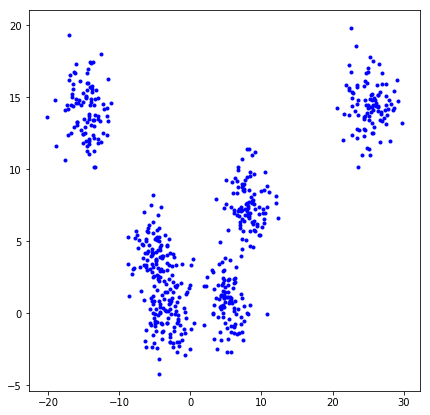

In [122]:
# A two dimensional example
fig = plt.figure()

N = 100
d0 = 1.6*np.random.randn(N,2)
d0[:,0]= d0[:,0] - 3
plt.plot(d0[:,0],d0[:,1],'.b')

d1 = 1.6*np.random.randn(N,2)+7.6
plt.plot(d1[:,0],d1[:,1],'.b')

d2 = 1.6*np.random.randn(N,2)
d2[:,0]= d2[:,0] + 5
d2[:,1]= d2[:,1] + 1
plt.plot(d2[:,0],d2[:,1],'.b')

d3 = 1.6*np.random.randn(N,2)
d3[:,0]= d3[:,0] - 5
d3[:,1]= d3[:,1] + 4
plt.plot(d3[:,0],d3[:,1],'.b')


d4 = 1.8*np.random.randn(N,2)
d4[:,0]= d4[:,0] - 15
d4[:,1]= d4[:,1] + 14
plt.plot(d4[:,0],d4[:,1],'.b')


d5 = 1.8*np.random.randn(N,2)
d5[:,0]= d5[:,0] + 25
d5[:,1]= d5[:,1] + 14
plt.plot(d5[:,0],d5[:,1],'.b')
Data1 = np.concatenate((d0,d1,d2,d3,d4,d5))
fig.set_size_inches(7,7)

In [123]:
data = Data1
mapsize = [40,40]
trainlen = 400
W, qe,Ws = train_som_online(data,mapsize,trainlen)
codebook = denormalize_by(data, W, n_method = 'var')

6.66666666667 0.666666666667
iteration 0: alpha: 0.5, raduis: 6.66666666667 and quantization error is 0.126508823145
iteration 10: alpha: 0.142857142857, raduis: 6.51629072682 and quantization error is 0.0972843279406
iteration 20: alpha: 0.0833333333333, raduis: 6.36591478697 and quantization error is 0.0940800817693
iteration 30: alpha: 0.0588235294118, raduis: 6.21553884712 and quantization error is 0.0908885178021
iteration 40: alpha: 0.0454545454545, raduis: 6.06516290727 and quantization error is 0.0867500566601
iteration 50: alpha: 0.037037037037, raduis: 5.91478696742 and quantization error is 0.0838066766138
iteration 60: alpha: 0.03125, raduis: 5.76441102757 and quantization error is 0.0800105126377
iteration 70: alpha: 0.027027027027, raduis: 5.61403508772 and quantization error is 0.0774970927323
iteration 80: alpha: 0.0238095238095, raduis: 5.46365914787 and quantization error is 0.0748491453416
iteration 90: alpha: 0.0212765957447, raduis: 5.31328320802 and quantization e

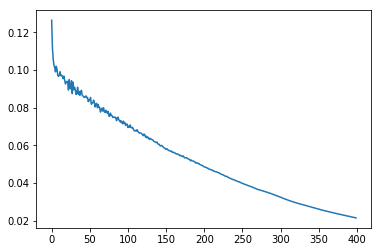

In [124]:
plt.plot(qe)

In [100]:
# Double pendulum formula translated from the C code at
# http://www.physics.usyd.edu.au/~wheat/dpend_html/solve_dpend.c

from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

# data_n = normalize_by(data, data, method='var');
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(data.min(axis=0)[0],data.max(axis=0)[0]), ylim=(data.min(axis=0)[1],data.max(axis=0)[1]))
# ax.grid()

dataplt, = ax.plot([], [], '.k',markersize=3)
somplt, = ax.plot([], [], 'o',markersize=3,alpha=.5,markerfacecolor='None',markeredgecolor='green')
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    dataplt.set_data([], [])
    somplt.set_data([], [])
    time_text.set_text('')
    return dataplt,somplt, time_text


def animate(i):
    dataplt.set_data(data[:,0],data[:,1])
    somplt.set_data(Ws[i][:,0],Ws[i][:,1])
    
    time_text.set_text(time_template % (i))
    return dataplt,somplt, time_text

ani = animation.FuncAnimation(fig, animate, np.arange(0, trainlen),
                              interval=25, blit=True, init_func=init)

# ani.save('./Images/double_pendulum.mp4', fps=15)
ani.save('./Images/SOM.mp4', fps=15, extra_args=['-vcodec', 'libx264'],dpi=200)
plt.close()

In [125]:
from IPython.display import HTML
HTML("""
<video width="600" height="400" controls>
  <source src="files/Images/SOM.mp4" type="video/mp4">
</video>
""")

# Batch training algorithm
### faster, and parallelizable
https://github.com/sevamoo/SOMPY

In [126]:
import sompylib.sompy as SOM
msz11 =40
msz10 = 40
X = Data1
som1 = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som1.init_map()
# som1.train(trainlen=None,n_job = 1, shared_memory = 'no',verbose='final')
som1.train(n_job = 1, shared_memory = 'no',verbose='final')

codebook1 = som1.codebook[:]
codebook1_n = SOM.denormalize_by(som1.data_raw, codebook1, n_method = 'var')



/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 8.688000 secodns
final quantization error: 0.015449


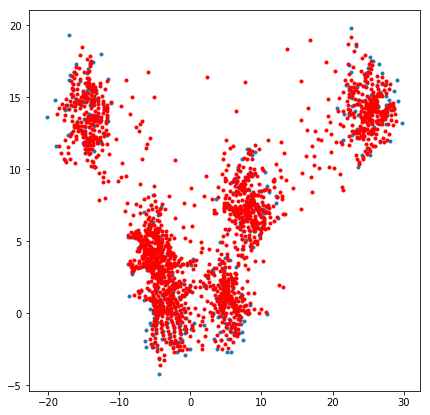

In [127]:
fig = plt.figure()
plt.plot(data[:,0],data[:,1],'.')
plt.plot(codebook1_n[:,0],codebook1_n[:,1],'.r')
fig.set_size_inches(7,7)

# Applications of SOM
* ** Dimensionality Reduction and Visualization of High Dimensional Spaces"**
    * ** Feature selection**
    * ** Multi-criteria Optimization**
* ** Clustering**
* ** Classification**
* ** Space transmorformation similar to PCA, K-means, Sparse Coding,...**
* ** Function approximation**
* ** Transfer function : Multidirectional function approximantion**
* ** Non parametric Probability density estimation**
    * ** filling missing values**
    * **resampling**
* ** Data Reduction and Abstraction similar to K-means with a large K**


# Applications of SOM
## Dimensionality Reduction and Visualization of High Dimensional Spaces"**
* ** Feature selection**
* ** Multi-criteria Optimization**


## A new way of visualizing the space

#### Note: This is a new space, and it should not be mixed with data space

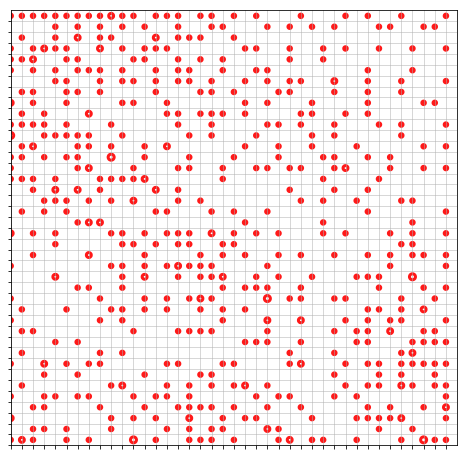

In [128]:
som1.hit_map()

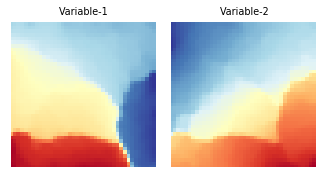

In [15]:
som1.view_map(text_size=8)

# An example with high dimensional data


## Feature extraction in engineering experiments
### In many real engineering applications, we are intersted to know what are the important factors in an experiment.
### Imagine, each experiment takes few hours and considering the combinations of all values of different variable explodes the experimental space!!!
### in the following case, we have 5 parameters and one label which says the label of the experiment

In [129]:
path = "./Data/CFD.csv"
D = pd.read_csv(path)
# D  = D[['Rent','ZIP','Year built','Living space','lng','lat']]
D.head()


P1     P2     P3        P4        P5  Label
0  11.00   7.50   5.75  0.001750  0.000500      1
1   5.75  11.00   9.25  0.001125  0.001750      1
2   9.25   9.25  11.00  0.001750  0.003000      1
3   9.25  11.00  11.00  0.001750  0.002375      1
4  11.00  11.00  11.00  0.000500  0.002375      1

### If we use one to one plots and with colors show the labels, usually we don't get any thing

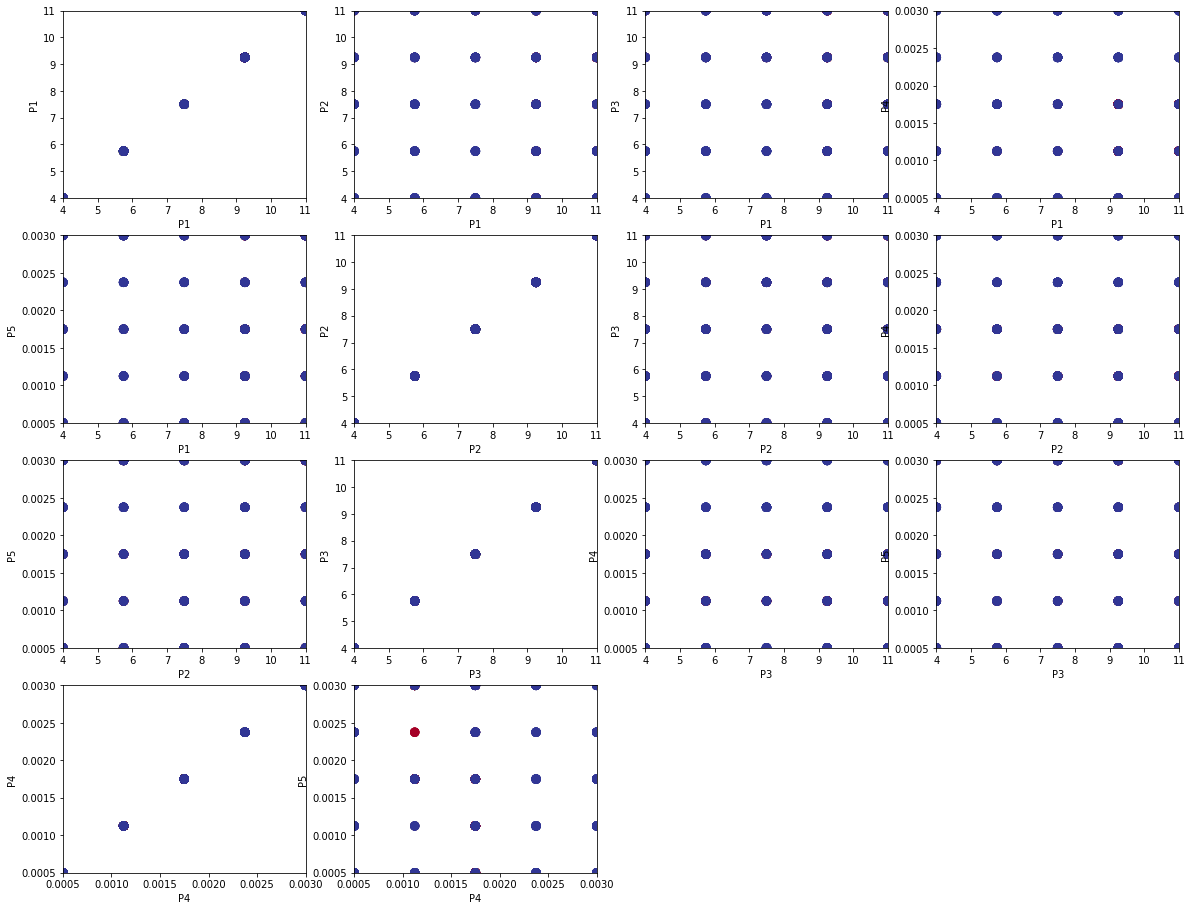

In [130]:
c = 1
fig = plt.figure(figsize=(20,20))
for i in range(0,4):
    for j in range(i,5):
                
        if i != j:
            plt.subplot(5,4,c);
            c = c +1;
            plt.scatter(D.values[:,i],D.values[:,j],marker='o',s=70,edgecolors=None,alpha=1.,vmin=0,vmax=1,c=plt.cm.RdYlBu_r(D.Label.values[:].astype(float)));
            plt.xlim((D.values[:,i].min(),D.values[:,i].max()));
            plt.ylim((D.values[:,j].min(),D.values[:,j].max()));
            plt.xlabel(D.columns[i]);
            plt.ylabel(D.columns[j]);
        if i == j:
            plt.subplot(5,4,c);
            c = c +1;
            plt.scatter(D.values[:,i],D.values[:,j],marker='o',s=70,edgecolors=None,alpha=1.,vmin=0,vmax=1,c=plt.cm.RdYlBu_r(D.Label.values[:].astype(float)));
            plt.xlim((D.values[:,i].min(),D.values[:,i].max()));
            plt.ylim((D.values[:,j].min(),D.values[:,j].max()));
            plt.xlabel(D.columns[i]);
            plt.ylabel(D.columns[j]);

# if we take the usual correlations

In [18]:
D.corr()

P1        P2        P3        P4        P5     Label
P1     1.000000 -0.020883 -0.089509 -0.036360  0.031264  0.383061
P2    -0.020883  1.000000  0.082728 -0.084491  0.042166  0.168023
P3    -0.089509  0.082728  1.000000 -0.023677  0.012584  0.144121
P4    -0.036360 -0.084491 -0.023677  1.000000 -0.118082 -0.220599
P5     0.031264  0.042166  0.012584 -0.118082  1.000000 -0.020029
Label  0.383061  0.168023  0.144121 -0.220599 -0.020029  1.000000

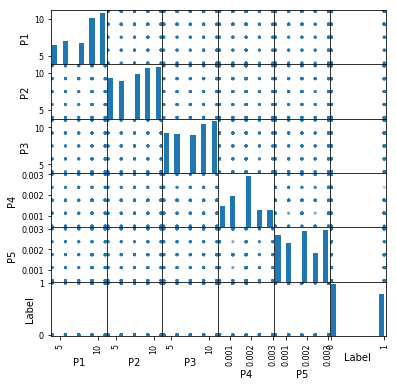

In [131]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(D, alpha=0.2, figsize=(6, 6), diagonal='hist');

# But now if we train a SOM with the parameters and visualize their labels 

In [29]:
import sompylib.sompy as SOM

msz11 =70
msz10 = 70

X = D.values[:,:-1]

som2 = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
# som1 = SOM1.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som2.init_map()
som2.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook1 = som2.codebook[:]
codebook1_n = SOM.denormalize_by(som2.data_raw, codebook1, n_method = 'var')
som2.compname= [D.columns[:-1]]

/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 215.823000 secodns
final quantization error: 0.116649


In [33]:
# We project data 
som2.cluster_labels = np.asarray(["" for i in range(som2.nnodes)])
bmus = som2.project_data(X)
Df = pd.DataFrame(data=bmus,columns=['bmu'])
Df['dlabel'] = D['Label']
Df.head()
gb = Df.groupby(by='bmu').median()
sel_bmus = gb.index.values[:]
print sel_bmus.shape
sel_bmus_label = gb.dlabel.values[:]
som2.cluster_labels[sel_bmus]= sel_bmus_label

(725,)


In [34]:
def viewmap_withlabel(som,data=None):
    if hasattr(som, 'cluster_labels'):
        codebook = getattr(som, 'cluster_labels')

    else:
        print 'clustering based on default parameters...'
        codebook = som.cluster()
    msz =  getattr(som, 'mapsize')
    fig = plt.figure(figsize=(20,14))
    dim = som.codebook.shape[1]
    no_row_in_plot = dim/3 + 1 #6 is arbitrarily selected
    if no_row_in_plot <=1:
        no_col_in_plot = dim
    else:
        no_col_in_plot = 3
    
    
    for k in range(dim):
        ax = plt.subplot(no_row_in_plot,no_col_in_plot,k+1)
    
        if data == None:
#             data_tr = getattr(som, 'data_raw')
#             proj = som.project_data(data_tr)
#             coord = som.ind_to_xy(proj)
            cents = som.ind_to_xy(np.arange(0,msz[0]*msz[1]))
            for i, txt in enumerate(codebook):
                ax.annotate(txt, (cents[i,1],cents[i,0]),size=8, va="center")
        if data != None:
            proj = som.project_data(data)
            cents = som.ind_to_xy(proj)
            label = codebook[proj]
            for i, txt in enumerate(label):
                ax.annotate(txt, (cents[i,1],cents[i,0]),size=8, va="center")

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(som.codebook[:,k].reshape(msz[0],msz[1])[::],alpha=1,cmap=plt.cm.RdYlBu_r)
#         ax.imshow(som.codebook[:,k].reshape(msz[0],msz[1])[::],alpha=1,cmap=plt.cm.Accent_r)
    plt.subplots_adjust(hspace = .001,wspace=.01)
#     plt.tight_layout()

# Here, the trained SOM unfolds the spcae nicely
## Only one variable is heavily correlating with the final results of the tests!

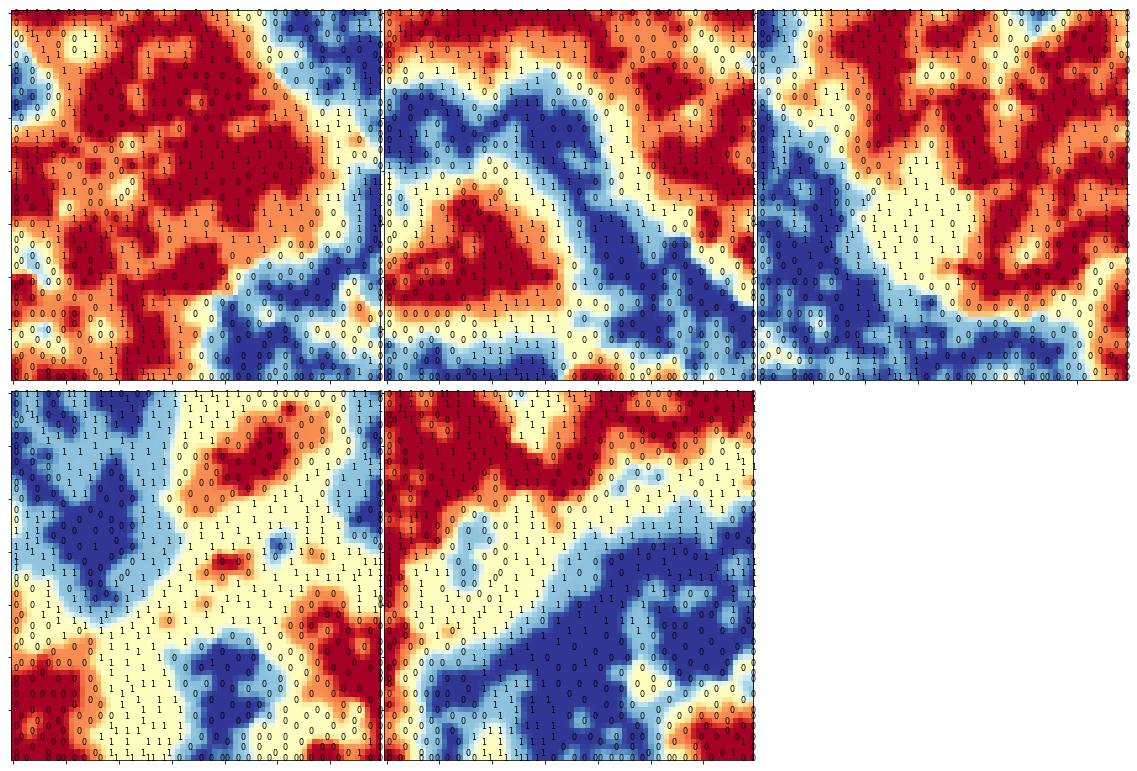

In [35]:
viewmap_withlabel(som2)

# Applications of SOM

### Clustering
### 1- If we use a SOM with very few nodes --- > K-means
### 2- Using SOM as data smoothing + K-means on the nodes
### 3- Using the so-called emergent SOM and U-Matrix

### Clustering
### 2- Using SOM as data smoothing + K-means on the nodes

In [44]:
import sompylib.sompy as SOM
msz11 =10
msz10 = 10
X = Data1
somM = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
somM.init_map()
# som1.train(trainlen=None,n_job = 1, shared_memory = 'no',verbose='final')
somM.train(n_job = 1, shared_memory = 'no',verbose='final')


codebookM = somM.codebook[:]
codebookM_n = SOM.denormalize_by(somM.data_raw, codebookM, n_method = 'var')


Total time elapsed: 0.030000 secodns
final quantization error: 0.096312


/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


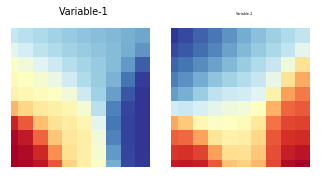

In [47]:
somM.view_map()

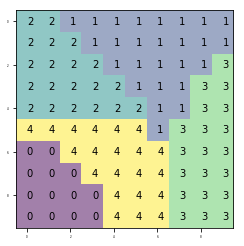

In [55]:
K = 4

somM.cluster(n_clusters=K+1);
somM.hit_map_cluster_number();

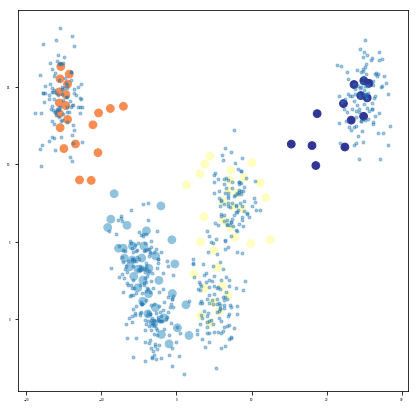

In [56]:
cl = somM.cluster(method='Kmeans', n_clusters=K)
fig = plt.figure()
plt.plot(X[:,0],X[:,1],'.',alpha=.4)
plt.scatter(codebookM_n[:,0],codebookM_n[:,1],s=60,marker='o',alpha=1.,c=plt.cm.RdYlBu_r(np.asarray(cl)/float(K)));
fig.set_size_inches(7,7);

### Clustering
### 3- Using the so-called emergent SOM and U-Matrix

### Solves many problems such as
#### selecting K
#### shape of the clusters
#### and density of the clusters

In [10]:
import sompylib.sompy as SOM
msz11 =30
msz10 = 30
X = Data1
somL = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
somL.init_map()
# som1.train(trainlen=None,n_job = 1, shared_memory = 'no',verbose='final')
somL.train(n_job = 1, shared_memory = 'no',verbose='final')


codebookL = somL.codebook[:]
codebookL_n = SOM.denormalize_by(somL.data_raw, codebookL, n_method = 'var')

/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 1.447000 secodns
final quantization error: 0.024364


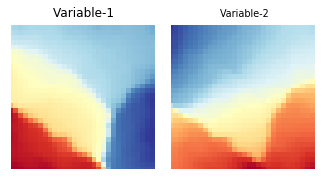

In [11]:
somL.view_map(text_size=8)

### U-Matrix Clustering
### U-Matrix : Calculates the average similarity of each node with its neighborhood
### P-Matrix: calculates the density of data around each node

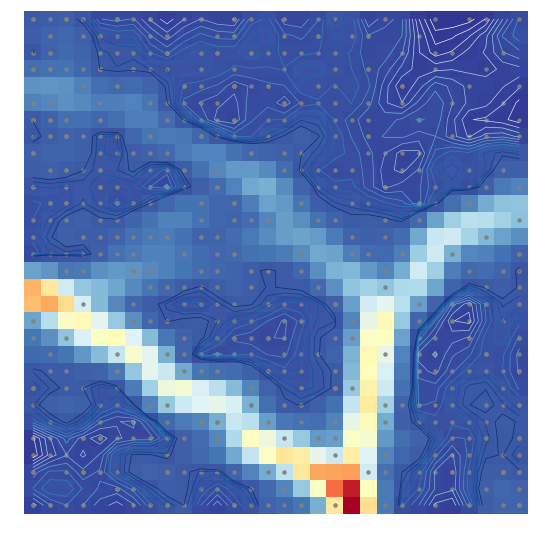

In [12]:
U = somL.view_U_matrix(distance2=2, row_normalized='No', show_data='Yes', contooor='Yes', blob='No', save='NO', save_dir='')

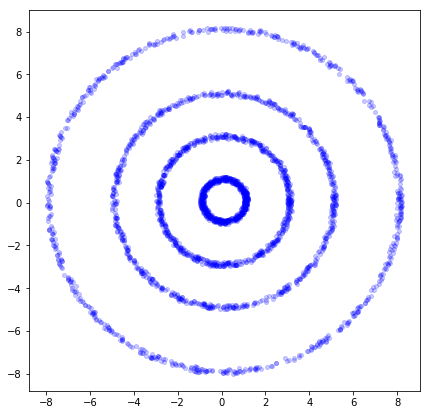

In [132]:
dlen = 700
tetha = np.random.uniform(low=0,high=2*np.pi,size=dlen)[:,np.newaxis]
X1 = 3*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y1 = 3*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D1 = np.concatenate((X1,Y1),axis=1)

X2 = 1*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y2 = 1*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D2 = np.concatenate((X2,Y2),axis=1)

X3 = 5*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y3 = 5*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D3 = np.concatenate((X3,Y3),axis=1)

X4 = 8*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y4 = 8*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D4 = np.concatenate((X4,Y4),axis=1)



Data3 = np.concatenate((D1,D2,D3,D4),axis=0)

fig = plt.figure()
plt.plot(Data3[:,0],Data3[:,1],'ob',alpha=0.2, markersize=4)
fig.set_size_inches(7,7)

In [133]:
import sompylib.sompy as SOM
msz11 =40
msz10 = 40
X = Data3
somL = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
somL.init_map()
# som1.train(trainlen=None,n_job = 1, shared_memory = 'no',verbose='final')
somL.train(n_job = 1, shared_memory = 'no',verbose='final')


codebookL = somL.codebook[:]
codebookL_n = SOM.denormalize_by(somL.data_raw, codebookL, n_method = 'var')

/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 3.003000 secodns
final quantization error: 0.017507


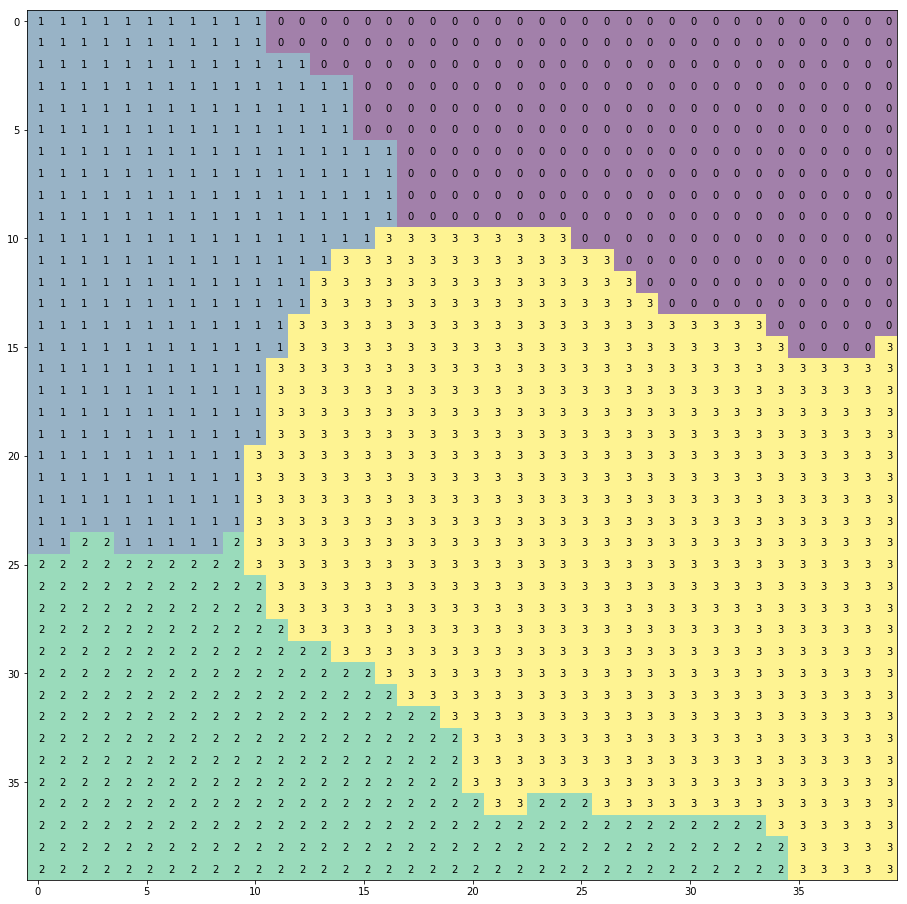

In [4]:
somL.cluster(n_clusters=4);
somL.hit_map_cluster_number();

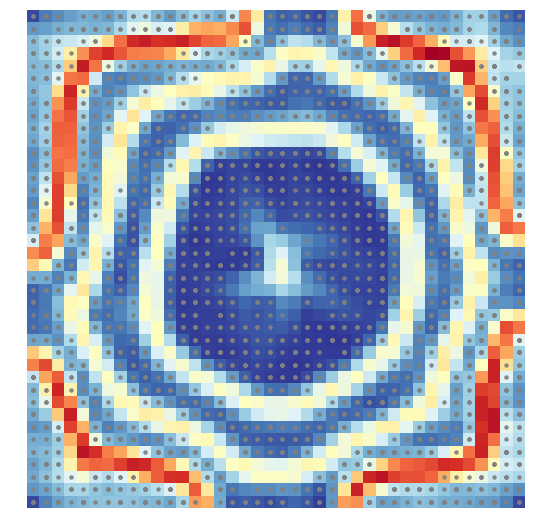

In [5]:
U = somL.view_U_matrix(distance2=2, row_normalized='No', show_data='Yes', contooor='No', blob='No', save='NO', save_dir='')

# Applications of SOM
* ** Classification**
* ** Function approximation**
* ** Transfer function : Multidirectional function approximantion**

### SOM is an unsupervised learning algorithm and it tries to learn the probabilistic distribution of the data
### Then, in principle, we can bias it toward certain target variable or after training we ask conditional questions. 
### For classification there are two main approaches
* **to train one SOM with/without labels. Then, we project the new data to SOM and look what are the labels around the selected node. using this method, it is possible to come up with probabilistic classifications**
* ** To train one SOM for each class/labels. Then, project a new data points to all of these SOMs and see the activation of each SOM. This also can be used for probabilistic classification** 

* 
* ** For function approximation/prediction we have similar set up, but comparing to other function approximation methods, here there is no out put/response variable. Therefore, we can ask questions from any directions**


# Regression example

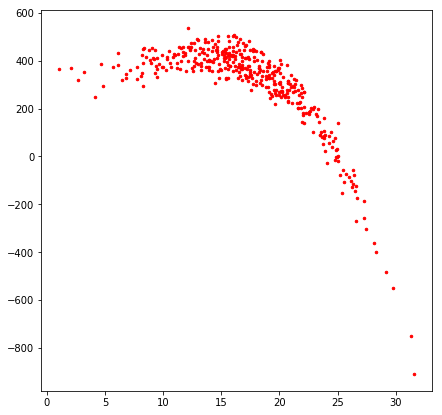

In [134]:
N = 400
x1= np.random.normal(loc=17,scale=5,size=N)[:,np.newaxis]
x2= np.random.normal(loc=0,scale=5,size=N)[:,np.newaxis]
y = 3*x1 + np.random.normal(loc=.0, scale=.4, size=N)[:,np.newaxis]

# x1 = np.random.uniform(size=N)[:,np.newaxis]
# y = np.sin(2*np.pi*x1**3)**3 + .1*np.random.randn(*x1.shape)

y =-.1*x1**3 + 2*x1*x1 + 2*np.sqrt(x1)+ 10*np.random.normal(loc=30.0, scale=4.7, size=len(x1))[:,np.newaxis]


fig = plt.figure(figsize=(7,7))
ax1= plt.subplot(111)
plt.plot(x1,y,'.r',markersize=5,alpha=1 );

In [135]:
def polynomial_regr(degree=1):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn import linear_model
    
    
    
    X_tr = x1[:].astype(float)
    y_tr = y[:].astype(float)
    
#     X_ts = x1[150:]
#     y_ts = y[150:]
    
    poly = PolynomialFeatures(degree=degree)
    X_tr_ = poly.fit_transform(X_tr)
#     X_ts_ = poly.fit_transform(X_ts)
    
    regr = linear_model.LinearRegression()
    regr.fit(X_tr_, y_tr)
    
    
    y_pred_tr = regr.predict(X_tr_)[:]
#     y_pred_ts = regr.predict(X_ts_)[:]
    # Predicting the training data
    plt.plot(X_tr,y_tr,'.r',markersize=3,alpha=.4 );
    plt.plot(X_tr,y_pred_tr,'.b',markersize=3,alpha=.4 );

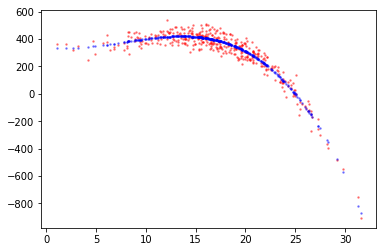

In [136]:
from ipywidgets import interact, HTML, FloatSlider
polynomial_regr(degree=3)


# Now with a SOM

## with no idealized function

In [137]:
import sompylib.sompy as SOM

msz11 =20
msz10 = 20

X_tr = x1[:].astype(float)
y_tr = y[:].astype(float)
X = np.concatenate((X_tr,y_tr),axis=1)
print X.shape
som2 = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
# som1 = SOM1.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som2.init_map()
som2.train(n_job = 1, shared_memory = 'no',verbose='final')


(400, 2)


/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 0.304000 secodns
final quantization error: 0.045699


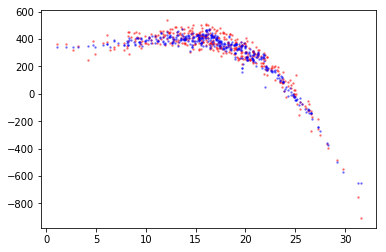

In [138]:
preds = som2.predict(X_tr,K=3)
plt.plot(X_tr,y_tr,'.r',markersize=3,alpha=.4 );
plt.plot(X_tr,preds,'.b',markersize=3,alpha=.4 );

# How to interpret SOM algorithm?
## is it a dimensionality reduction or not?


# Two types of space transformations

# PCA as a global geometric space transformation
![](Images/PCATransform.png)

# Local toology preserving transformations
![](Images/topological_transformation.png)

#### Picture is for LLE 


# SOM is more toward the second approach

## In that sense, usually it is considered as dimensionality reduction method
## However, in addition to dimensionality reduction method, SOM has data abstraction in the nodes. In that sense, similar to PCA, Sparse Coding or K-means with large K, each node of the SOM can be seen as a new dimension.

## In this way, we can look at SOM in a different way, using dot products.


# "usual" Way of using SOM
## Each node is a dimension itself


In [142]:
# We use MNIST DATA
from sklearn.datasets import fetch_mldata
DATA_PATH = './Data/MNIST/'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)

In [143]:
train = mnist.data[:60000]
# train[train>0]=1
test = mnist.data[60000:]
# test[test>0]=1
Data_tr = train + 1e-32*np.random.randn(train.shape[0],train.shape[1])
# Data_tr = train
labels = mnist.target[:]
test_labels = labels[60000:]
train_labels = labels[:60000]

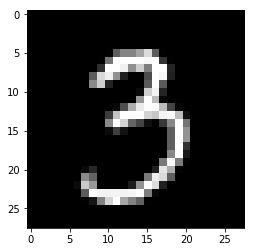

In [144]:
fig  = plt.imshow(train[20000].reshape(28,28),cmap='gray')

In [145]:
tr_low = 0
tr_up = 60 *1000
msz1 = 50
msz0 = 50


In [146]:

Tr_data = Data_tr[tr_low:tr_up].astype(float)
perm = np.random.permutation(Tr_data.shape[0])
somMNIST = SOM.SOM('som1', Tr_data[perm], mapsize = [msz0, msz1],norm_method = 'var',initmethod='random')
# som1 = SOM.SOM('som1', D, mapsize = [1, 100],norm_method = 'var',initmethod='pca')
somMNIST.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_MNIST = somMNIST.codebook[:]


Total time elapsed: 22.933000 secodns
final quantization error: 20.287761


In [147]:
codebook_MNIST_n = denormalize_by(somMNIST.data_raw, codebook_MNIST, n_method = 'var')

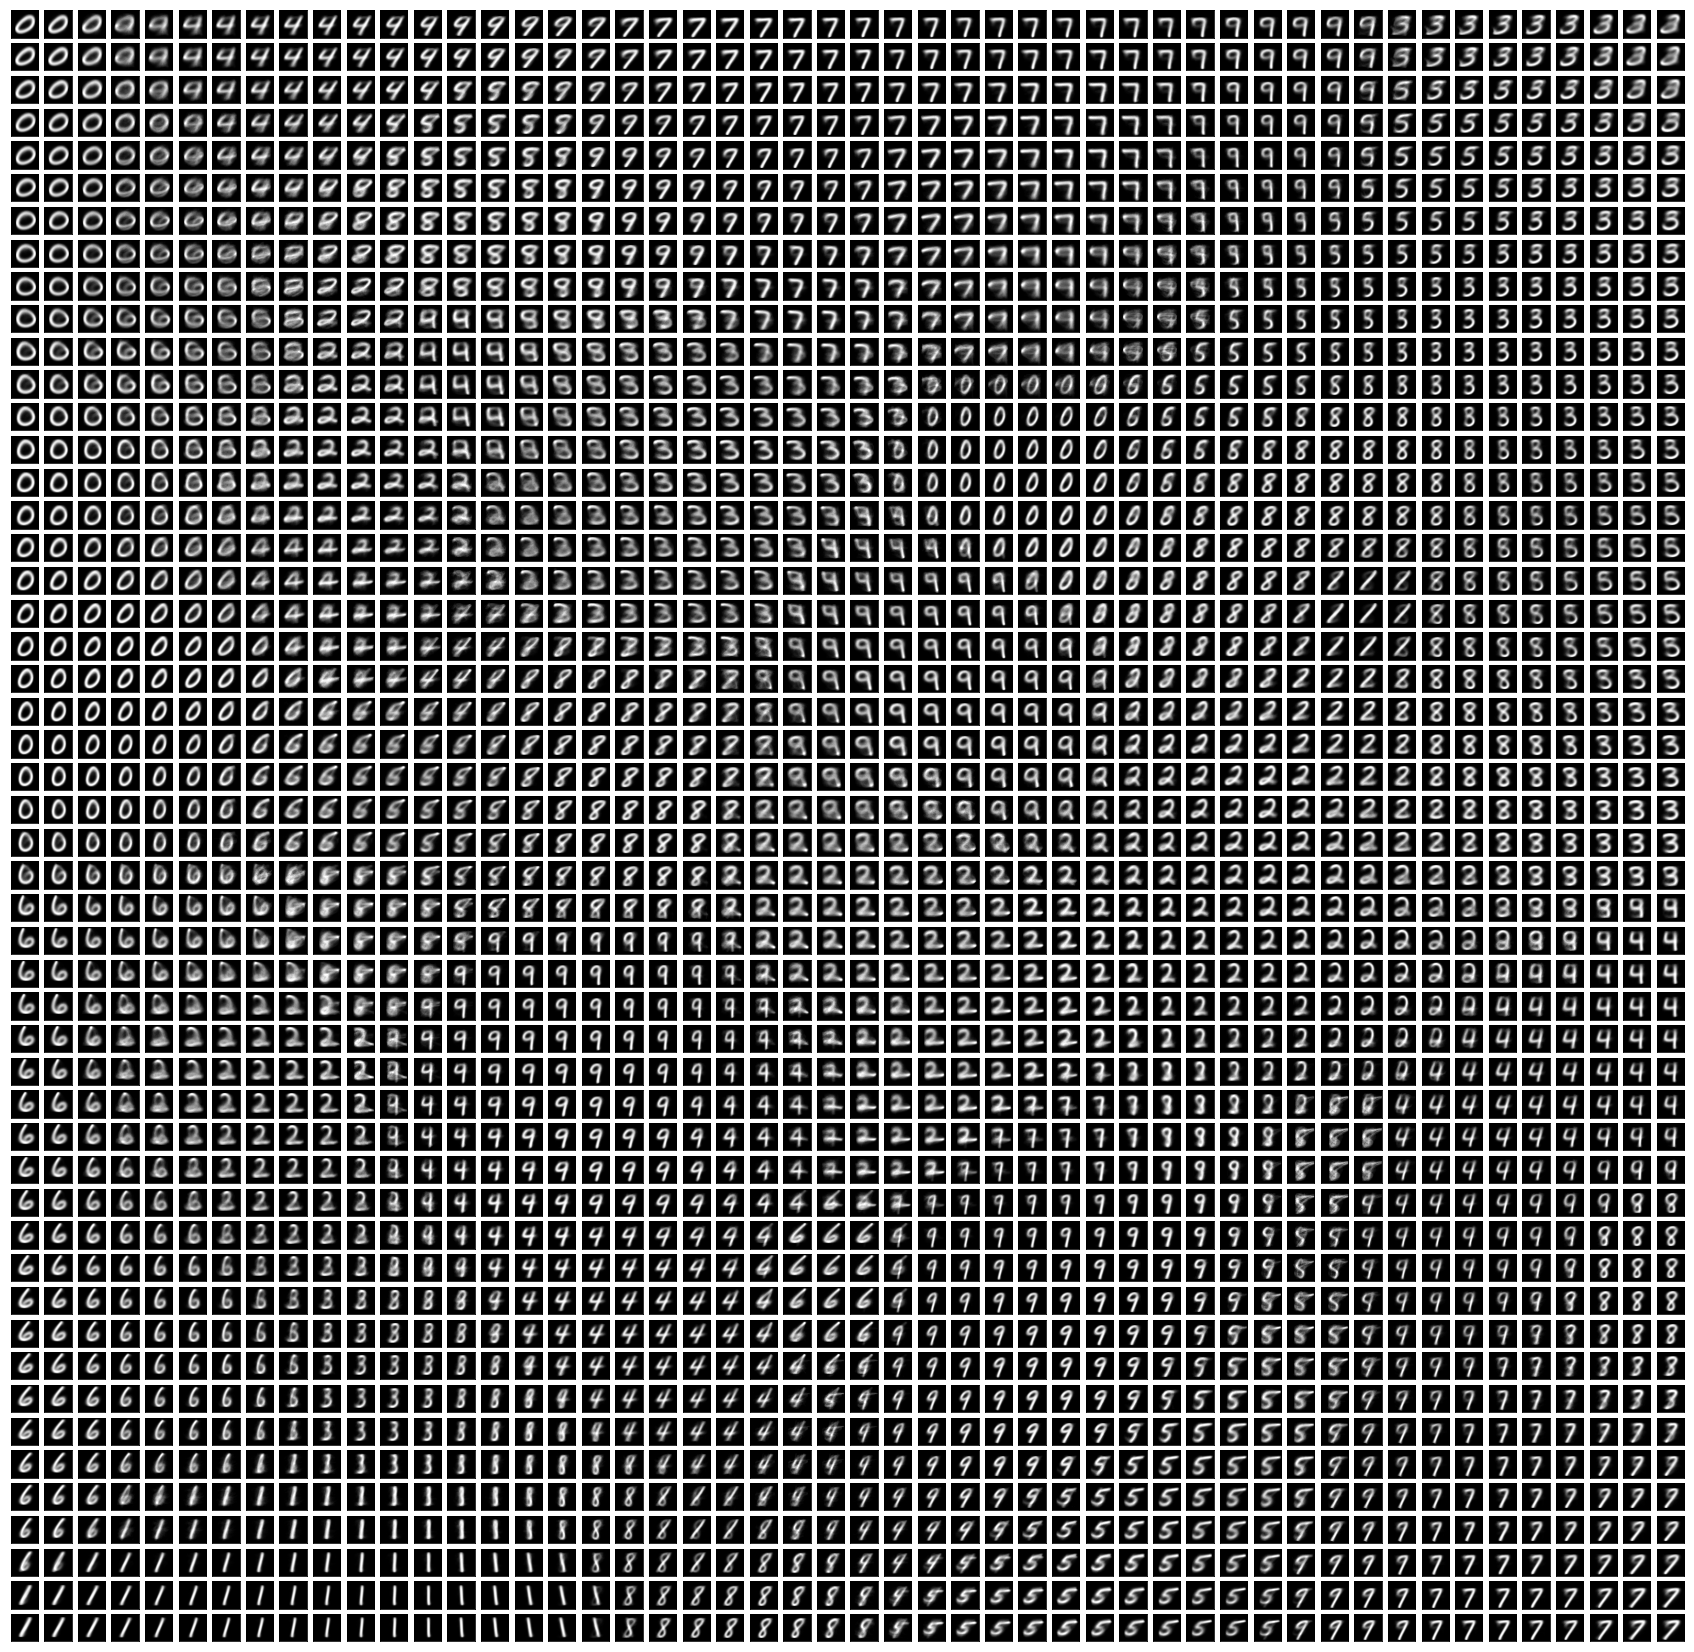

In [21]:
c = 0;
fig = plt.figure(figsize=(30,30))
for i in range(msz0):
    for j in range(msz1):
        plt.subplot(msz0,msz1,c+1);
        plt.imshow(codebook_MNIST_n[c].reshape(28,28),cmap='gray')
        c = c +1
        plt.xticks([])
        plt.yticks([])
fname = path = "./Data/MINISTSOM.jpeg"
fig.savefig(fname, dpi=200)


# Second way of using SOM 
# Dictionary learning, where each node is a dimension for itself
## Therefore, it is not just a dimensionality reduction method

# Now let's use these components, each as a dimension
# Then, in principle, using dot product, we calculate the share of each dimension

In [148]:
# Some test data
import random
ind_row_test = random.sample(range(test.shape[0]),9)
ind_row_test = range(5000,5009)
x_to_proj = test[ind_row_test]
labels_to_proj = test_labels[ind_row_test]
print x_to_proj.shape
print labels_to_proj

(9, 784)
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.]


In [149]:
# Adding nonlinearities and normalizing the results 

def sigmoid(x):
    return 1/(1+np.exp(-.03*x))

def tanh(x):
    return sigmoid(2*x) - sigmoid(-2*x)

# With SOM
### Each plot is the activation of the whole SOM regarding the input data
### Therefore, we expect that data with similar labels, regardless of their deformations have similar activations

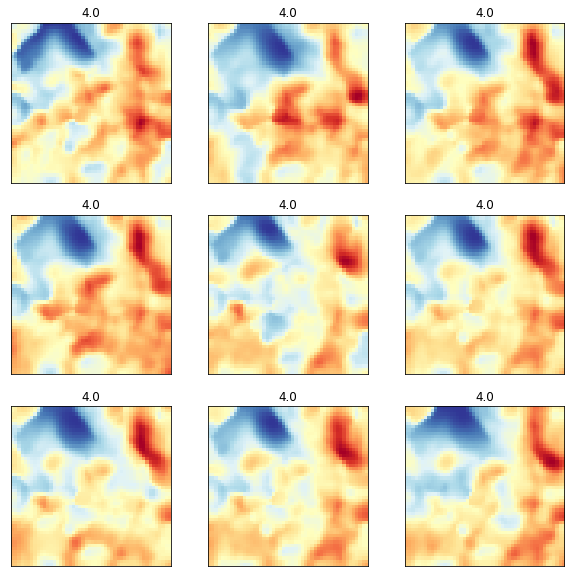

In [150]:
activation = x_to_proj.dot(codebook_MNIST_n.T)
fig = plt.figure(figsize=(10,10));
for i in range(x_to_proj.shape[0]):
    plt.subplot(3,3,i+1);
    sig_acivatio = sigmoid(activation[i])
    sig_acivatio = tanh(activation[i])
    sig_acivatio = activation[i]
    
    plt.imshow(sig_acivatio.reshape(msz0,msz1),cmap=plt.cm.RdYlBu_r);
    plt.title(labels_to_proj[i]);
    plt.xticks([]);
    plt.yticks([]);

# <a></a>
# In classification/ Prediction, now we can use these activations as features
# We will discuss these issues later.
# The same process happens in Deep Networks in a sequential manner.

# <a></a>

# Also could train one SOM for each class 
#### Gives good results for binary classifications
#### Though not a good idea for cases with a lot of labels

In [33]:
tr_low = 0
tr_up = 5500
msz1 = 20
msz0 = 20
Tr_data = Data_tr[tr_low:tr_up].astype(float)
perm = np.random.permutation(Tr_data.shape[0])
somMNIST_0 = SOM.SOM('som1', Tr_data[perm], mapsize = [msz0, msz1],norm_method = 'var',initmethod='random')
# som1 = SOM.SOM('som1', D, mapsize = [1, 100],norm_method = 'var',initmethod='pca')
somMNIST_0.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_MNIST_0 = somMNIST_0.codebook[:]
codebook_MNIST_n_0 = denormalize_by(somMNIST_0.data_raw, codebook_MNIST_0, n_method = 'var')


Total time elapsed: 0.537000 secodns
final quantization error: 22.066228


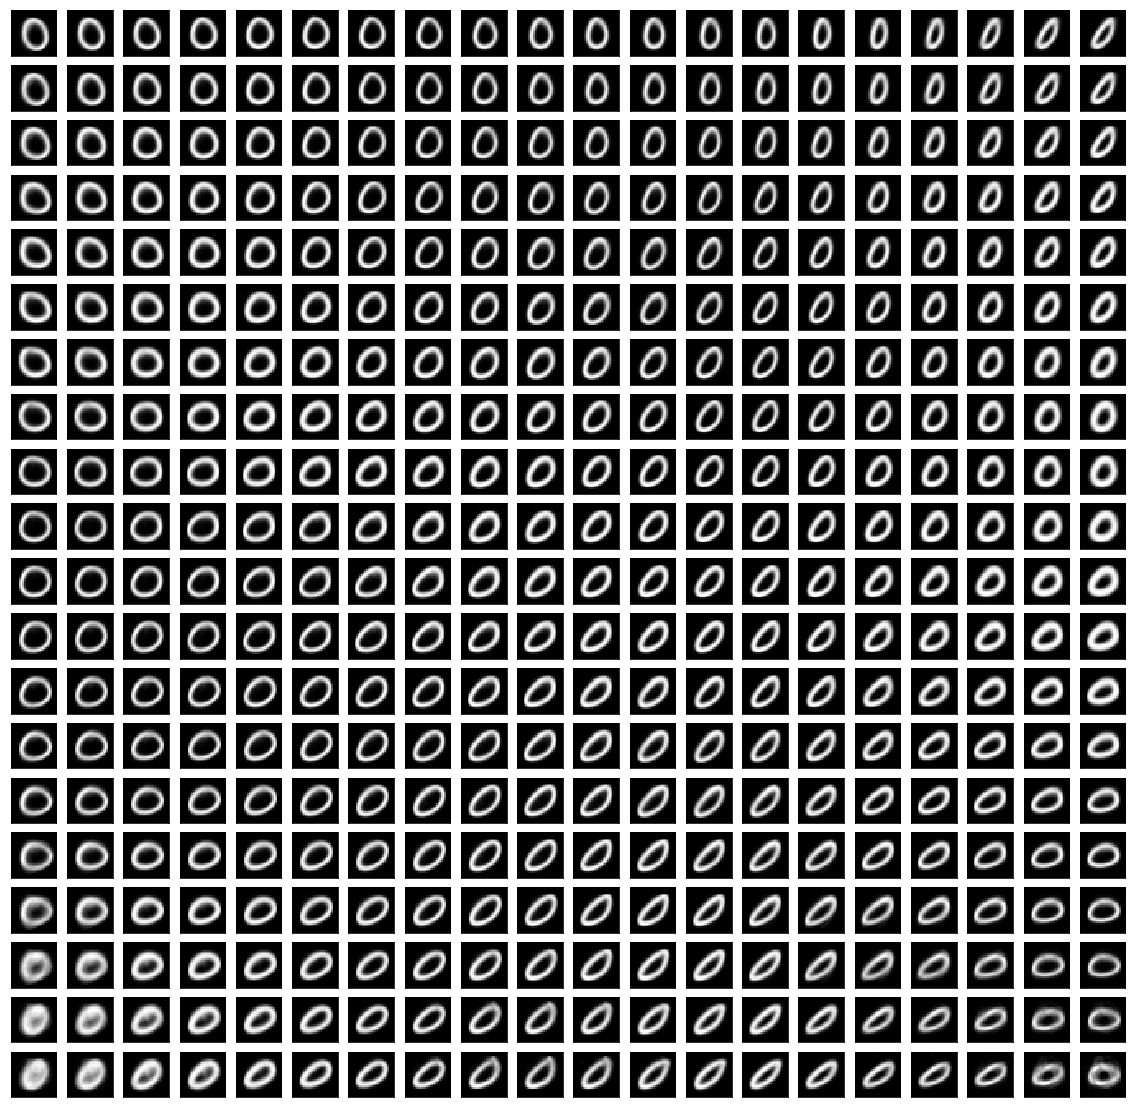

In [34]:
c = 0;
fig = plt.figure(figsize=(20,20))
for i in range(msz0):
    for j in range(msz1):
        plt.subplot(msz0,msz1,c+1);
        plt.imshow(codebook_MNIST_n_0[c].reshape(28,28),cmap='gray')
        c = c +1
        plt.xticks([])
        plt.yticks([])

In [35]:
tr_low = 6000
tr_up = 10000
msz1 = 20
msz0 = 20
Tr_data = Data_tr[tr_low:tr_up].astype(float)
perm = np.random.permutation(Tr_data.shape[0])
somMNIST_1 = SOM.SOM('som1', Tr_data[perm], mapsize = [msz0, msz1],norm_method = 'var',initmethod='random')
# som1 = SOM.SOM('som1', D, mapsize = [1, 100],norm_method = 'var',initmethod='pca')
somMNIST_1.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_MNIST_1 = somMNIST_1.codebook[:]
codebook_MNIST_n_1 = denormalize_by(somMNIST_1.data_raw, codebook_MNIST_1, n_method = 'var')


Total time elapsed: 0.514000 secodns
final quantization error: 20.011634


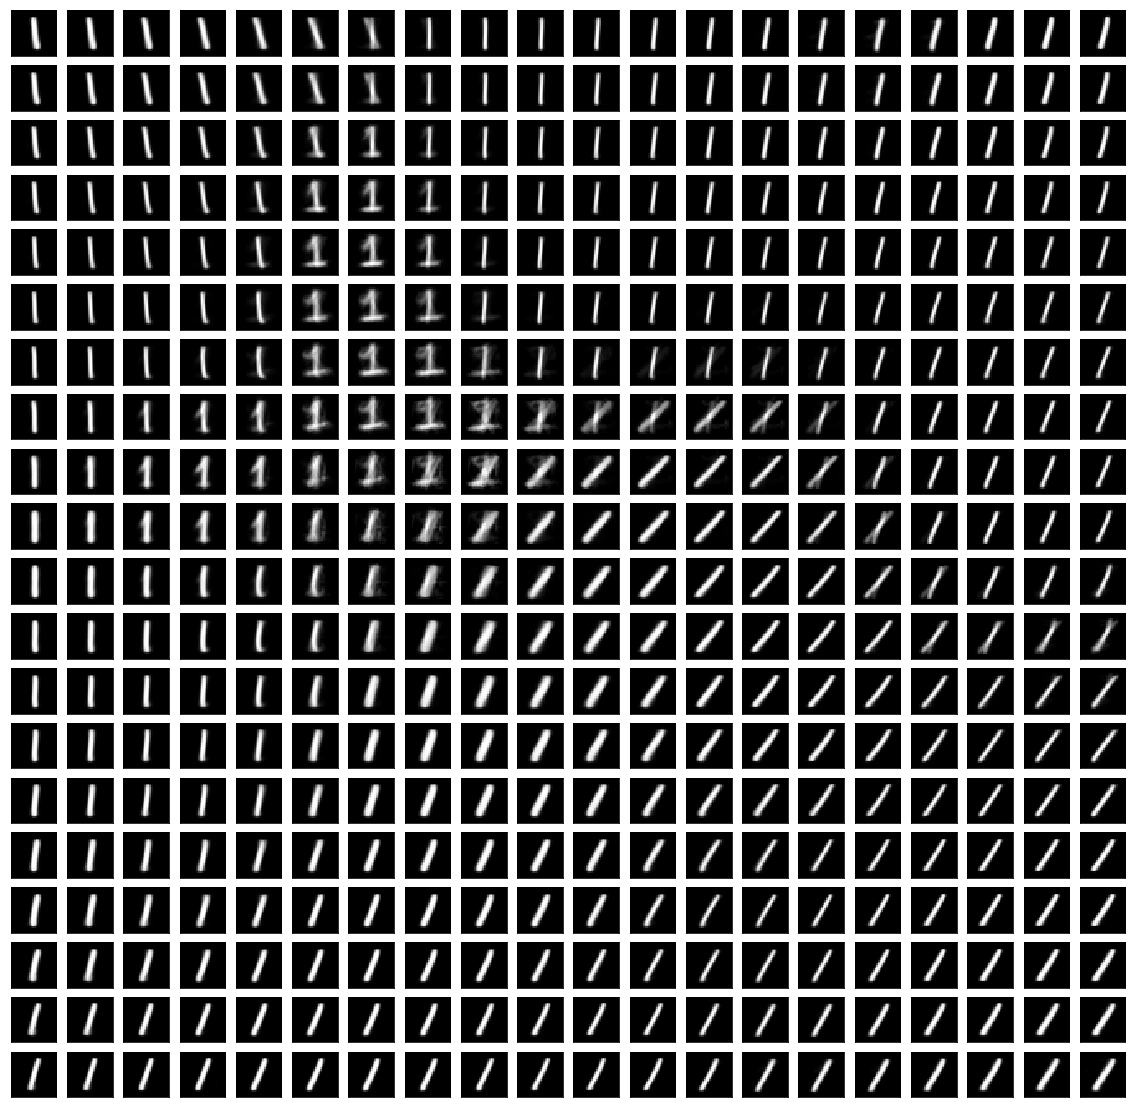

In [36]:
c = 0;
fig = plt.figure(figsize=(20,20))
for i in range(msz0):
    for j in range(msz1):
        plt.subplot(msz0,msz1,c+1);
        plt.imshow(codebook_MNIST_n_1[c].reshape(28,28),cmap='gray')
        c = c +1
        plt.xticks([])
        plt.yticks([])

In [42]:
# Now project new data to both SOMs 

import random
ind_row_test = random.sample(range(test.shape[0]),9)
ind_row_test = range(1000,1009)
x_to_proj = test[ind_row_test]
labels_to_proj = test_labels[ind_row_test]
print x_to_proj.shape
print labels_to_proj

(9, 784)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


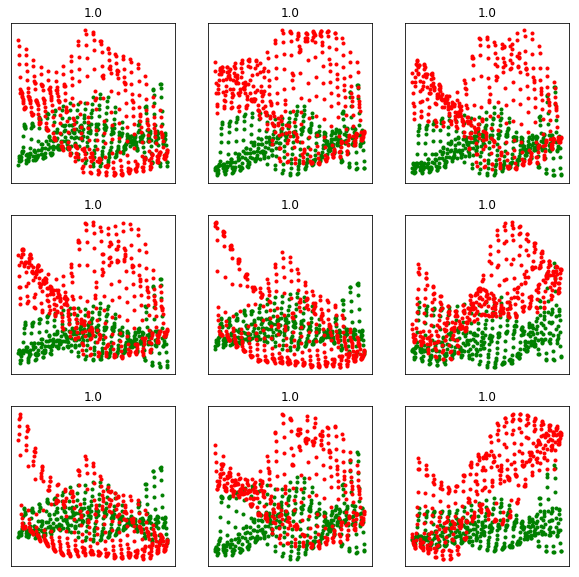

In [43]:
# If we project new data into som trained with label 0
activation_0 = x_to_proj.dot(codebook_MNIST_n_0.T)

# If we project new data into som trained with label 1
activation_1 = x_to_proj.dot(codebook_MNIST_n_1.T)
fig = plt.figure(figsize=(10,10));
for i in range(x_to_proj.shape[0]):
    plt.subplot(3,3,i+1);
    
    # Activation with label 0
    sig_acivatio = activation_0[i]
    plt.plot(range(sig_acivatio.shape[0]),sig_acivatio,'.g')
    
    # Activation with label 1
    sig_acivatio = activation_1[i]
    plt.plot(range(sig_acivatio.shape[0]),sig_acivatio,'.r')
    plt.title(labels_to_proj[i]);
    plt.xticks([]);
    plt.yticks([]);

# Different modifications to the original SOM

* **Topology of low dimensional space**
    * ** planar**
        * ** One-dimensional grid**
        * ** Two-dimensional grid**
    * **cylinder **
    * **Toroid**
    * **Spherical SOM**
* ** Growing SOM**
* ** Hierarchical SOM **
* ** Growing Hierarchical SOM**
* ** Neural Gas**
* ** Generative Topographic Map**
* ** Similarity Measures**
    * ** Relational SOM**
    * ** Median SOM**
    * **Vectorial representation or Non-vectorial SOM**


# SOM and Topological Data Analysis
## What is the topological shape of the data?
## what if we relax the assumption of fixed gid topology

In [87]:
def draw_neigborhood_graph(som,Sim_Matrix,Sim_thresh,lon_lat,nod_vol,nod_color,howmanynodes=None,k=5,which_nodes='all',layout='Spring'):
#     import community
    import networkx as nx
    import matplotlib.pyplot as plt
    
    G = nx.Graph()
    labels={}
    if howmanynodes== None:
        nod_sz = Sim_Matrix.shape[0]
    else:
        nod_sz = howmanynodes
#     print nod_sz 
    
    for i in range(nod_sz):
        G.add_node(i)

    
    
    for i in range(G.number_of_nodes()):
        for j in range(G.number_of_nodes()):
#             if dist_Mat[i,K_neighs.values[i,j]] !=0:
            if Sim_Matrix[i,j]>=Sim_thresh:
                G.add_edge(i,j,weight=abs(Sim_Matrix[i,j])) 



    if layout=='Spectral':
        pos = nx.spectral_layout(G)
    elif layout == 'Circular':
        pos = nx.circular_layout(G)
    elif layout == 'Spring':
        pos = nx.spring_layout(G)
    elif layout == 'Geo':
        pos = dict()
        for i in range(nod_sz):
            pos[i]= lon_lat[i,[1,0]]
#         plot_state_border(state)
    else:
        pos = nx.spring_layout(G)
        

    
#     dg = np.asarray(G.degree().values())
    dg = nod_vol
    vol_mx = float(max(dg))
    vol_mn = float(min(dg))
    dg = (dg-vol_mn)/(vol_mx-vol_mn)*100 + 10
    
    xy =np.asarray(pos.values())
    col_mn = np.min(nod_color)
    col_mx = np.max(nod_color)
#     nod_id = np.asarray(range(som.nnodes))
    cm = plt.cm.get_cmap('RdYlBu_r')
    
    edge_mn = Sim_thresh
    edge_mx = Sim_thresh+.05
    
    # nx.draw_networkx_labels(G,pos,labels,font_size=12)
#     nx.draw_networkx_edges(G,pos,width=.5, alpha=0.2,edge_cmap=cm, edge_vmin=edge_mn, edge_vmax=edge_mx)
    nx.draw_networkx_edges(G,pos,width=.07,alpha=0.1,edge_color='gray')
#     nx.draw_networkx_nodes(G, pos, G.nodes(), node_size = 10,node_color='w',alpha=.01)    

#     nod_color = nod_id
    sc = plt.scatter(xy[:,0],xy[:,1],c=nod_color,s=dg,vmin=col_mn,marker='.',
                     edgecolor='None', vmax=col_mx, cmap=cm ,alpha=.8)

#     plt.scatter(xy[:,0],xy[:,1], s= nod_vol, alpha=0.9,c=,marker='o',cmap='jet',linewidths=3, edgecolor = 'r'
#                 ,label='Proportional to the no. of represented data by')
    

    plt.xticks([])
    plt.yticks([])
#     plt.title('Similarity_thresh = '+str(Sim_thresh))
    plt.tight_layout()
    
#     fig.set_size_inches(10,10)
#     plt.show()
#     return pos

In [88]:
def sigmoid(x):
    return 1/(1+np.exp(-.03*x))

def tanh(x):
    return sigmoid(2*x) - sigmoid(-2*x)


In [151]:
import sompylib.sompy as SOM
msz11 =1
msz10 = 400
X = Data1
som1 = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som1.init_map()
# som1.train(trainlen=None,n_job = 1, shared_memory = 'no',verbose='final')
som1.train(n_job = 1, shared_memory = 'no',verbose='final')
bmus = som1.project_data(X)
print bmus.shape
bmu_freq = [(bmus==i).sum() for i in range(som1.nnodes)]
bmu_freq = np.asarray(bmu_freq)
bmu_xy = som1.ind_to_xy(np.arange(som1.nnodes))



/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 2.428000 secodns
final quantization error: 0.034236
(600,)


0.99
0.971
0.951
0.932
0.913
0.893
0.874
0.855
0.835
0.816
0.797
0.777
0.758
0.739
0.719
0.7


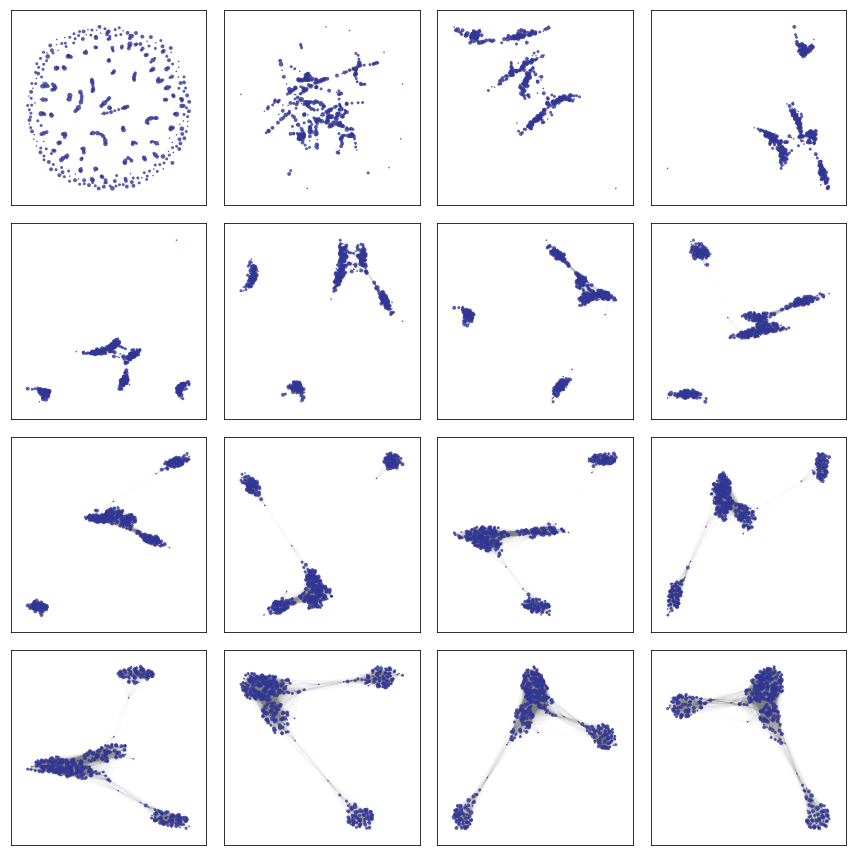

In [152]:
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise

import scipy
som = som1
# Sim_Matrix = scipy.spatial.distance_matrix(som.codebook,som.codebook)
Sim_Matrix = pairwise.euclidean_distances(som.codebook[:],som.codebook[:])


nod_color = np.asarray(range(som.nnodes))
nod_color = np.ones(som.nnodes)
nod_vol = tanh(bmu_freq[:])


pca = PCA(svd_solver='randomized',n_components=2) #Randomized PCA is scalable
pca = PCA(n_components=2)
pca.fit(som.codebook)
lon_lat = pca.transform(som.codebook)[:,:2]

mn = Sim_Matrix.min()
mx = Sim_Matrix.max()
Sim_Matrix = 1 - (Sim_Matrix-mn)/(mx-mn)
fig = plt.figure(figsize=(12,12))
for k,Sim_thresh in enumerate(np.linspace(.99,.70,16)):
    Sim_thresh = np.around(Sim_thresh,decimals=3)
    print Sim_thresh
    
    plt.subplot(4,4,k+1)
    layouts = ['Spring','Spectral','Circular','Geo']
    which_layout = 2
    l= draw_neigborhood_graph(som,Sim_Matrix,Sim_thresh,lon_lat,nod_vol,nod_color,howmanynodes=None,k=5,which_nodes='all',layout=layouts)

# In above example, we see that with different thresholds how the main shape of the data is emerging

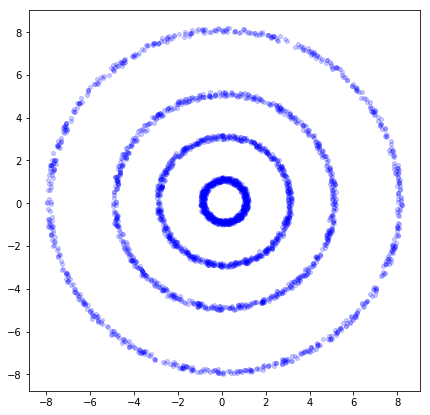

In [154]:
dlen = 700
tetha = np.random.uniform(low=0,high=2*np.pi,size=dlen)[:,np.newaxis]
X1 = 3*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y1 = 3*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D1 = np.concatenate((X1,Y1),axis=1)

X2 = 1*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y2 = 1*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D2 = np.concatenate((X2,Y2),axis=1)

X3 = 5*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y3 = 5*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D3 = np.concatenate((X3,Y3),axis=1)

X4 = 8*np.cos(tetha)+ .22*np.random.rand(dlen,1)
Y4 = 8*np.sin(tetha)+ .22*np.random.rand(dlen,1)
D4 = np.concatenate((X4,Y4),axis=1)



Data3 = np.concatenate((D1,D2,D3,D4),axis=0)

fig = plt.figure()
plt.plot(Data3[:,0],Data3[:,1],'ob',alpha=0.2, markersize=4)
fig.set_size_inches(7,7)

In [155]:
import sompylib.sompy as SOM
msz11 =1
msz10 = 400
X = Data3
som1 = SOM.SOM('', X, mapsize = [msz10, msz11],norm_method = 'var',initmethod='pca')
som1.init_map()
# som1.train(trainlen=None,n_job = 1, shared_memory = 'no',verbose='final')
som1.train(n_job = 1, shared_memory = 'no',verbose='final')
bmus = som1.project_data(X)
print bmus.shape
bmu_freq = [(bmus==i).sum() for i in range(som1.nnodes)]
bmu_freq = np.asarray(bmu_freq)
bmu_xy = som1.ind_to_xy(np.arange(som1.nnodes))



/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/Users/SVM/anaconda/envs/tensorflow/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)



Total time elapsed: 1.281000 secodns
final quantization error: 0.030455
(2800,)


0.99
0.971
0.951
0.932
0.913
0.893
0.874
0.855
0.835
0.816
0.797
0.777
0.758
0.739
0.719
0.7


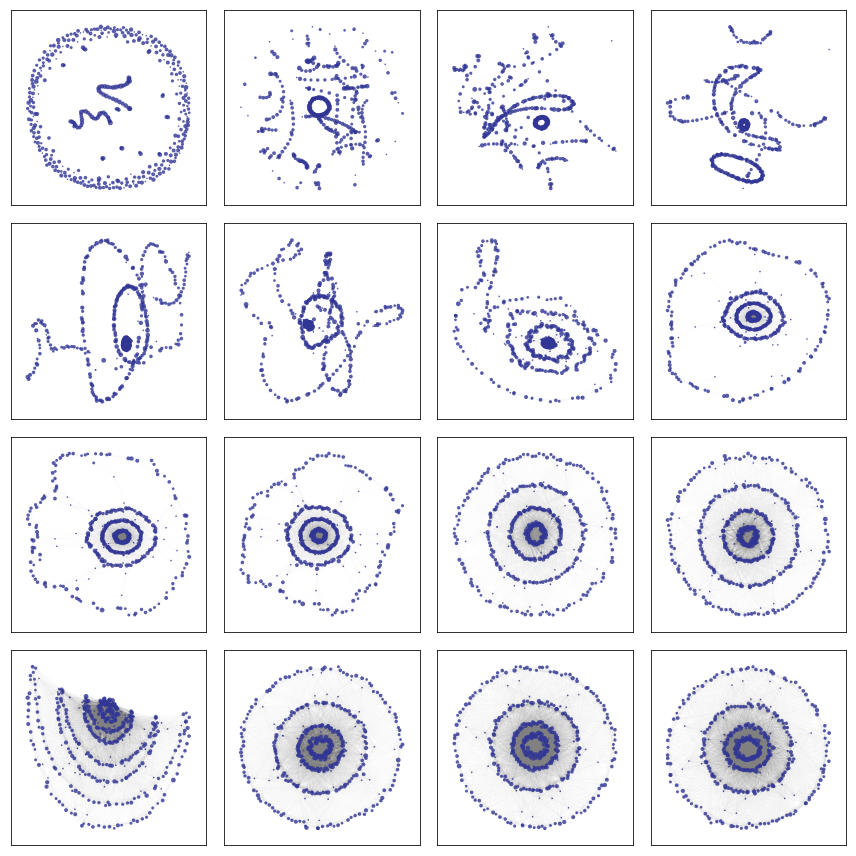

In [157]:
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise

import scipy
som = som1
# Sim_Matrix = scipy.spatial.distance_matrix(som.codebook,som.codebook)
Sim_Matrix = pairwise.euclidean_distances(som.codebook[:],som.codebook[:])


nod_color = np.asarray(range(som.nnodes))
nod_color = np.ones(som.nnodes)
nod_vol = tanh(bmu_freq[:])


pca = PCA(svd_solver='randomized',n_components=2) #Randomized PCA is scalable
pca = PCA(n_components=2)
pca.fit(som.codebook)
lon_lat = pca.transform(som.codebook)[:,:2]

mn = Sim_Matrix.min()
mx = Sim_Matrix.max()
Sim_Matrix = 1 - (Sim_Matrix-mn)/(mx-mn)
fig = plt.figure(figsize=(12,12))
for k,Sim_thresh in enumerate(np.linspace(.99,.70,16)):
    Sim_thresh = np.around(Sim_thresh,decimals=3)
    print Sim_thresh
    
    plt.subplot(4,4,k+1)
    layouts = ['Spring','Spectral','Circular','Geo']
    which_layout = 2
    l= draw_neigborhood_graph(som,Sim_Matrix,Sim_thresh,lon_lat,nod_vol,nod_color,howmanynodes=None,k=5,which_nodes='all',layout=layouts)

# This approache can be useful for high dimensional data sets.
## Example: main patterns of urban forms 
https://arxiv.org/pdf/1709.02939.pdf

# Further Discusssions
* **Convergence of the algorith**
* **Looking at SOM  not as a deterministic machine, but as a probabilistic machine!**
* **Resampling application**
* **Using online randomized SOM for several runs to find invariances**


# <a></a>
# <a></a>
# Convergence of the SOM algorithm

## There is not yet a closed form energy function to describe the SOM process


# If we look at K-means ojective function
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/debd28209802c22a6e6a1d74d099f728e6bd17a4)


## In comparison to Sparse Coding (SC) objective function
![](http://ufldl.stanford.edu/wiki/images/math/f/1/1/f110901ddedcba59e339de5f16c547da.png)





## SOM 


![](Images/SOMEnergy.png)



# if some body could find a good function, the SOM might become a single shot!

# Current theoretical methods are based on theories of stochastic systems, where each node is a dynamic system. 
## If the algotighm converges, we need to see that all nodes reach to a steady state. 

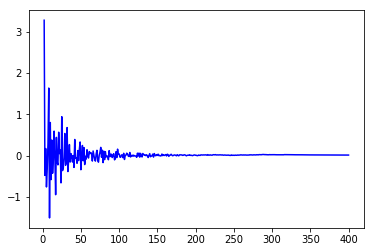

In [110]:
# Using the Weight vectors from the first example
# Here we calculate the difference between every two consecutive vectors of each node 
Ws.shape
j = 120
All_diffs = np.zeros((Ws.shape[1],Ws.shape[0]))
for j in range(Ws.shape[1]):
    diffs = []
    for i in range(0,Ws.shape[0]):
        diff = (Ws[i,j,:] -Ws[i-1,j,:]).sum()
        diffs.append(diff)
    All_diffs[j] = diffs   
plt.plot(range(2,Ws.shape[0]),diffs[2:],'-b');

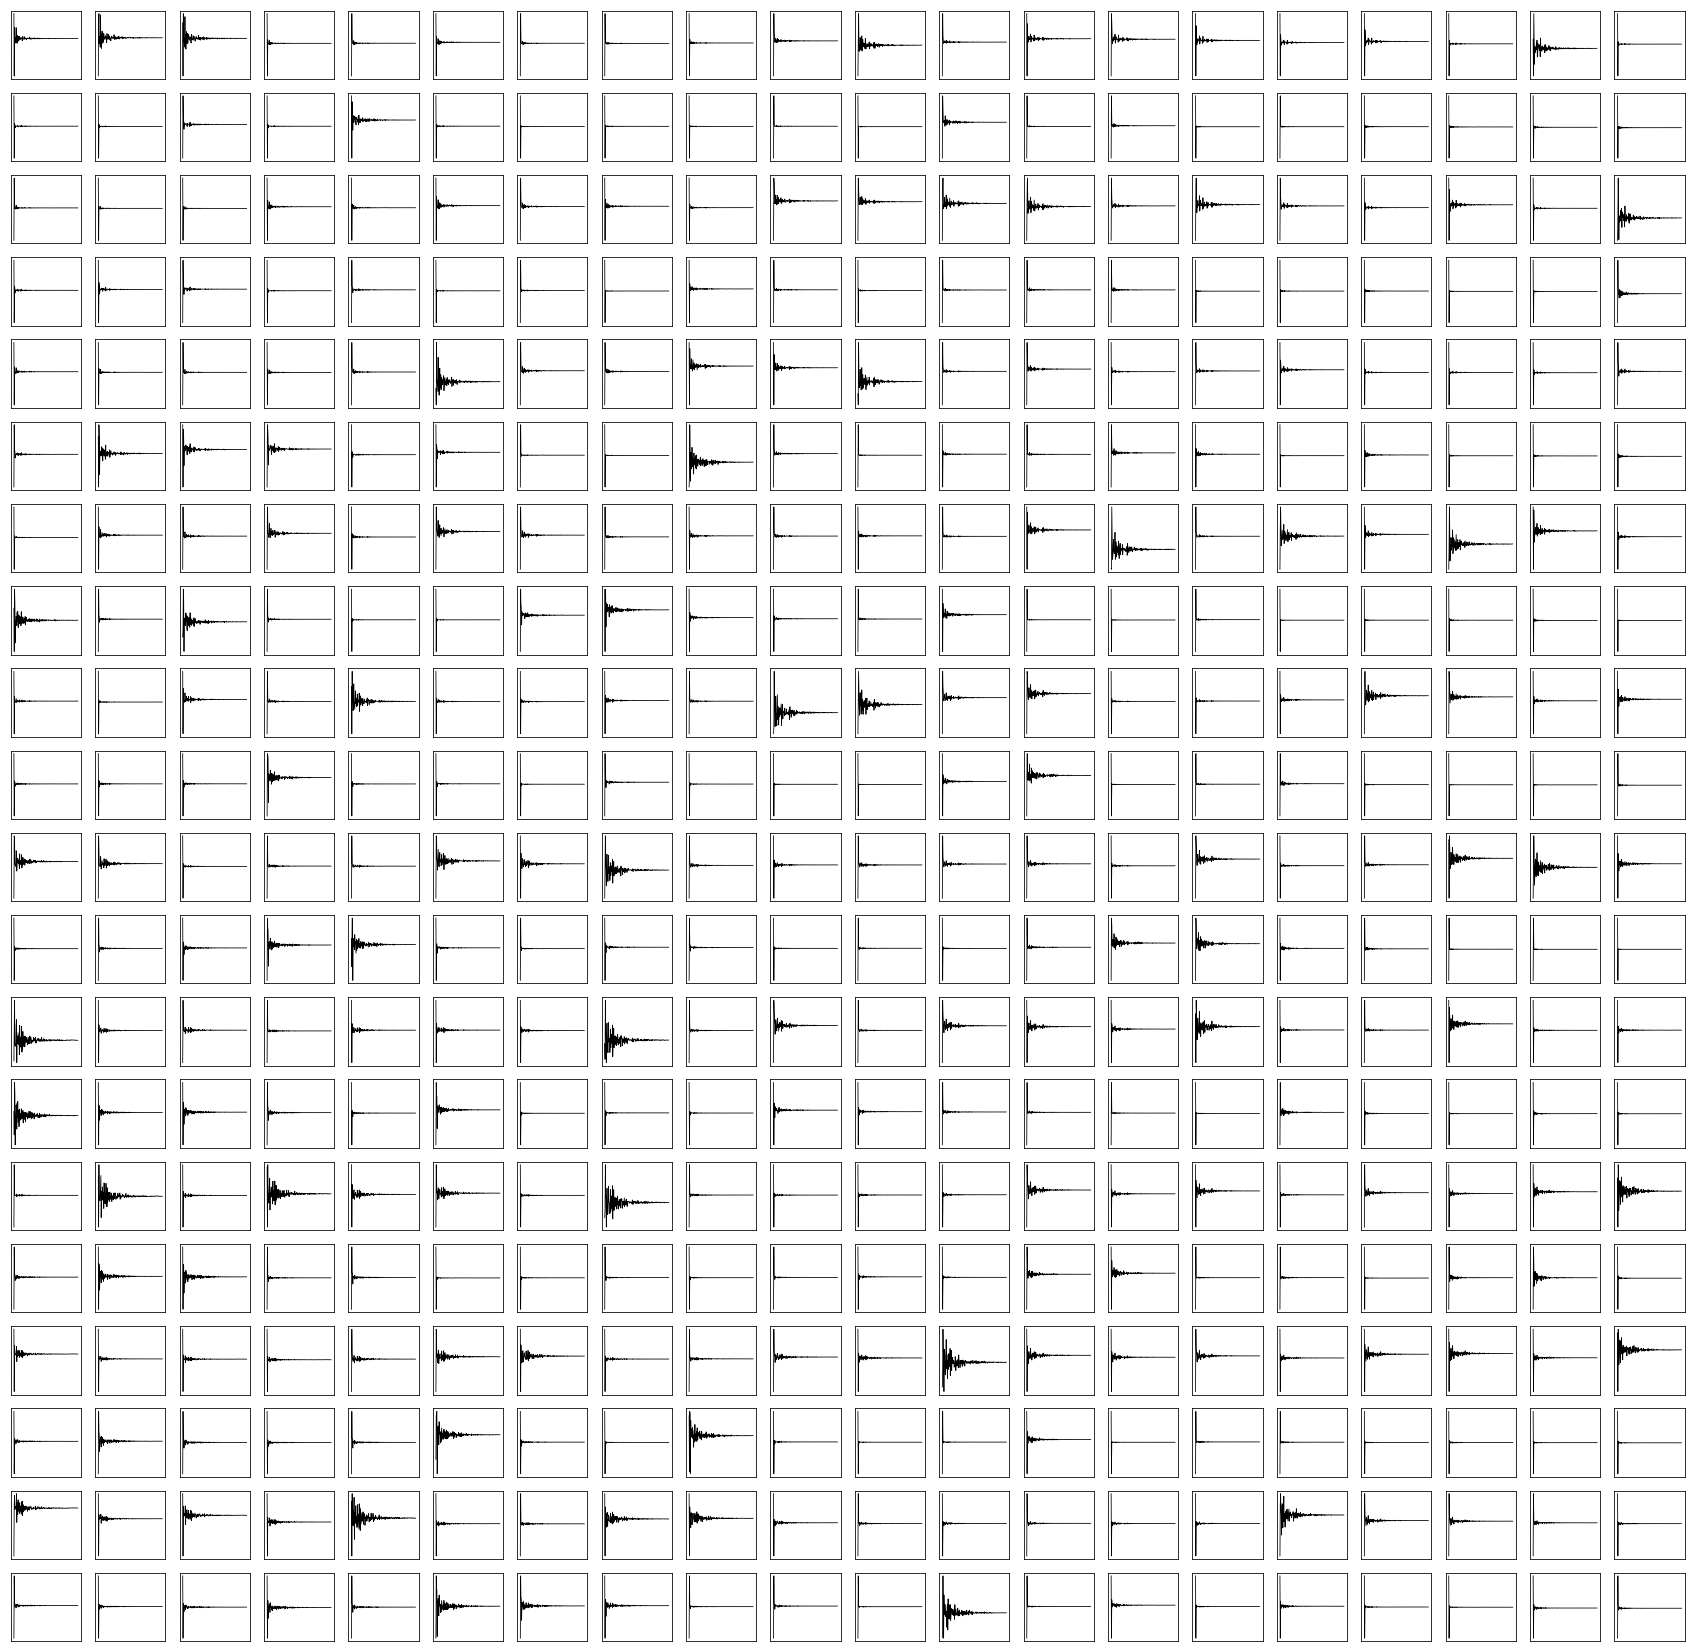

In [116]:
c = 0;
fig = plt.figure(figsize=(30,30))
for i in range(20):
    for j in range(20):
        plt.subplot(msz0,msz1,c+1);
        plt.plot(All_diffs[400+c][:200],'-k',linewidth=.8)
        c = c +1
        plt.xticks([])
        plt.yticks([])

# If we use a SOM for this data...

In [117]:
msz1 =20
msz0 = 20
somConverge= SOM.SOM('som1', All_diffs[:,2:], mapsize = [msz0, msz1],norm_method = 'var',initmethod='random')
# som1 = SOM.SOM('som1', D, mapsize = [1, 100],norm_method = 'var',initmethod='pca')
somConverge.train(n_job = 1, shared_memory = 'no',verbose='final')
codebook_Converge = somConverge.codebook[:]


Total time elapsed: 0.439000 secodns
final quantization error: 6.731176


In [118]:
# Here, we just sort the 

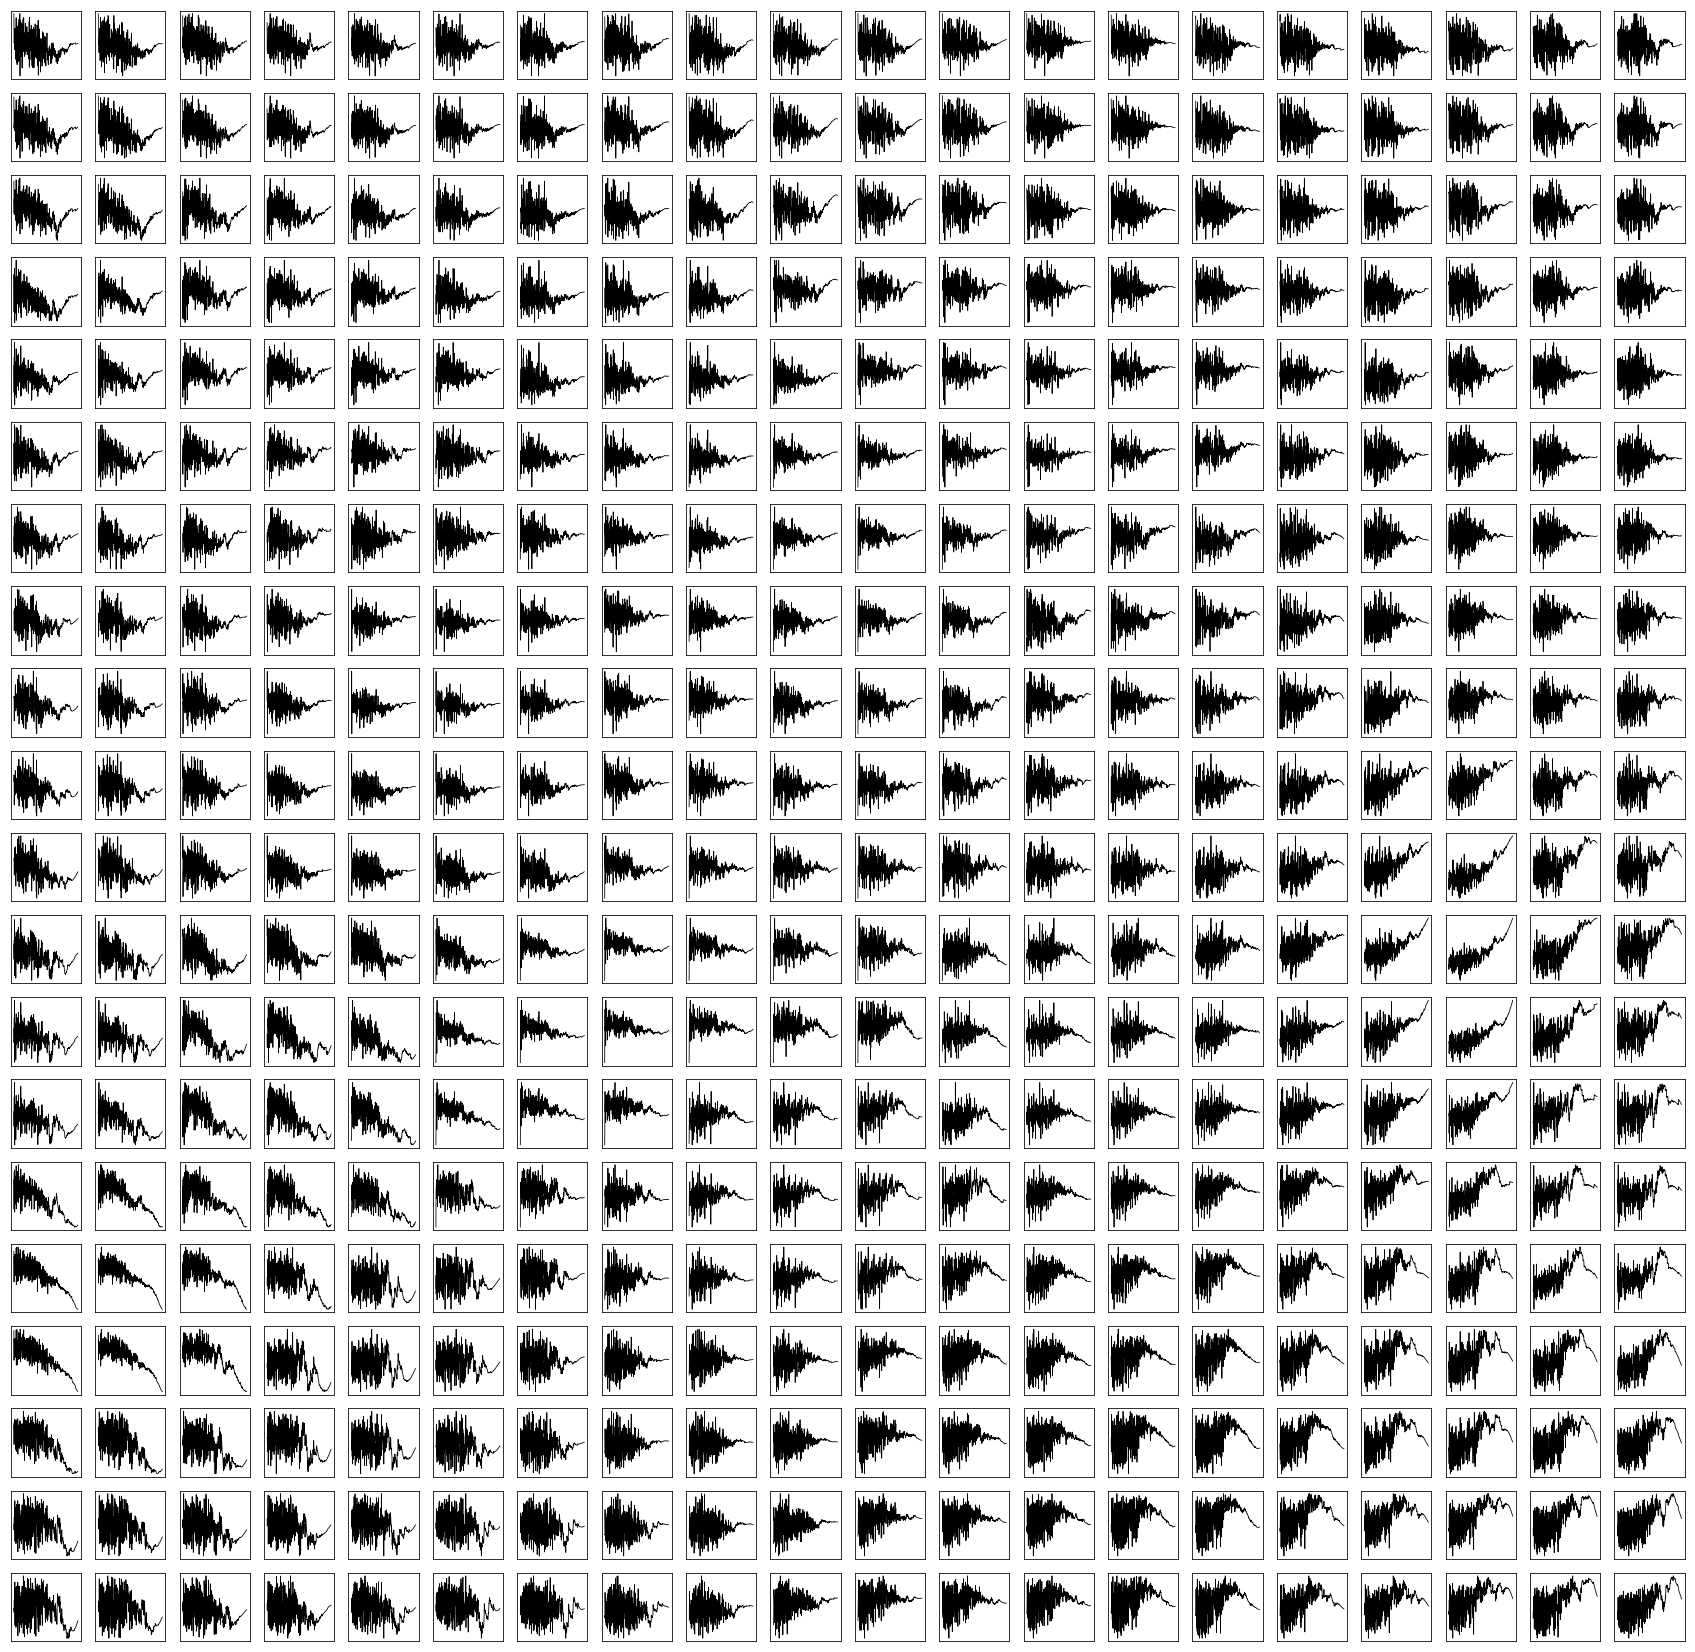

In [119]:
c = 0;
fig = plt.figure(figsize=(30,30))
for i in range(msz0):
    for j in range(msz1):
        plt.subplot(msz0,msz1,c+1);
        plt.plot(codebook_Converge[c],'-k',linewidth=.8)
        c = c +1
        plt.xticks([])
        plt.yticks([])